In [374]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import re

from IPython.display import display
pd.options.display.max_columns = 500

## Import data set

In [375]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

In [376]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Outliers

* We need to add justification

In [377]:
# remove outliers
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]

In [378]:
train = train[~((train['MasVnrArea'] > 1400) & (train['SalePrice'] < 300000))]

In [379]:
train = train[~((train['LotFrontage'] > 300) & (train['SalePrice'] < 300000 ))]

In [380]:
train = train[~((train['LotArea'] > 200000) & (train['SalePrice'] < 500000 ))]

In [381]:
# train = train[~((train['YearBuilt'] < 1900) & (train['SalePrice'] > 400000))]

In [382]:
train = train[~((train['OpenPorchSF'] > 500) & (train['SalePrice'] < 100000))]

In [383]:
# train.drop('TotalBsmtSF', axis= 1, inplace=True)
# test.drop('TotalBsmtSF', axis= 1, inplace=True)


# train['TwoStory'] = train['2ndFlrSF'].isna().apply(lambda x: int(not x))
# test['TwoStory'] = test['2ndFlrSF'].isna().apply(lambda x: int(not x))

# train['SF'] = train['1stFlrSF'] + train['2ndFlrSF']
# train.drop(['1stFlrSF','2ndFlrSF'], axis= 1, inplace=True)

# test['SF'] = test['1stFlrSF'] + test['2ndFlrSF']
# test.drop(['1stFlrSF','2ndFlrSF'], axis= 1, inplace=True)


## Remove SalePrice and Id

In [384]:
response_variable = np.log1p(train.SalePrice)
id_ = test.Id
train = train.loc[:,'MSSubClass':'SaleCondition']
test = test.loc[:,'MSSubClass':'SaleCondition']

## Multicoliearity 

We need to add justification

In [385]:
# drop some features to avoid multicollinearity
train.drop(['GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)
test.drop(['GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)

## Skewdness

In [386]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

Try different values

In [387]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.65]
skewed_feats = skewed_feats.index

train[skewed_feats] = boxcox1p(train[skewed_feats], 0.15)
test[skewed_feats] = boxcox1p(test[skewed_feats], 0.15)

## Dummification

In [388]:
train = pd.get_dummies(train)
train = train.fillna(train.mean())

In [389]:
test = test.fillna(test.mean())

In [390]:
test = pd.get_dummies(test)

In [391]:
train_cols = set(train.columns)
test_cols = set(test.columns)

test_drop =  list(test_cols - train_cols)
test_unkonwn_dummies = list(train_cols - test_cols)

In [392]:
test_dummies2 = test.reindex(columns=test_unkonwn_dummies, fill_value=0)

In [393]:
test = pd.concat([test, test_dummies2], axis=1)

In [394]:
test = test[train.columns]

In [395]:
train['SalePrice'] = response_variable

# Feature Engineering

## Age

In [396]:
# Yb = train_df['YearBuilt']

# range_bins = [(1800,1900), (1900,1910), (1910,1920), (1920,1930), (1930,1940), (1940,1950), (1950,1960), (1960,1970), (1970,1980), (1980,1990), (1990,2000), (2000,2011)]

# bins = {r:x for (x,y) in range_bins for r in range(x,y)}

# train_df = pd.concat([train_df.drop('YearBuilt', axis=1), Yb.map(bins)], axis=1)
# Yb = test_df['YearBuilt']

# test = pd.concat([test.drop('YearBuilt', axis=1), Yb.map(bins)], axis=1)


In [397]:
# train[['Age']] = train[['YearBuilt']].apply(lambda x: x.max() - x)
# train = train.drop('YearBuilt', axis=1)
# test[['Age']] = test[['YearBuilt']].apply(lambda x: x.max() - x)
# test = test.drop('YearBuilt', axis=1)

## Garage Age

In [398]:
# test['GarageYrBlt'] = test['GarageYrBlt'].isna().apply(lambda x: int(not x))

In [399]:
# train['GarageYrBlt'] = train['GarageYrBlt'].isna().apply(lambda x: int(not x))

In [400]:
# train['GarageYrBlt'] = train['YrSold'] - train['GarageYrBlt']

In [401]:
# test['GarageYrBlt'] = test['YrSold'] - test['GarageYrBlt']

## YearRemodAdd

In [402]:
# train['YearRemodAdd']  = (train['YrSold'] - train['YearRemodAdd'])
# test['YearRemodAdd']  = (test['YrSold'] - test['YearRemodAdd'])

In [403]:
# train.to_pickle('train.pkl')
# test.to_pickle('test.pkl')

In [410]:
# cont = train.T[np.array(train.nunique() > 70)].T.columns.drop('SalePrice')
# scale = StandardScaler()
# train[cont] = scale.fit_transform(train[cont])

# cont = test.T[np.array(test.nunique() > 70)].T.columns
# scale = StandardScaler()
# test[cont] = scale.fit_transform(test[cont])

## Train Test Split

In [405]:
#split
X_train = train.drop('SalePrice', axis=1)
X_test = test
y_train = response_variable

## Modeling

In [406]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=5000)

alphas = [.0004] #np.logspace(-4, -2, 100)

grid = GridSearchCV(estimator=lasso,
    param_grid=dict(alpha=alphas), cv=10, scoring='r2')

grid.fit(X_train, y_train)

y_hats = grid.best_estimator_.predict(X_train)
test_predictions = np.expm1(grid.best_estimator_.predict(X_test))

grid.best_estimator_.fit(X_train, y_train)
grid.best_estimator_.score(X_train, y_train)
grid.best_estimator_

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

## Prediciton

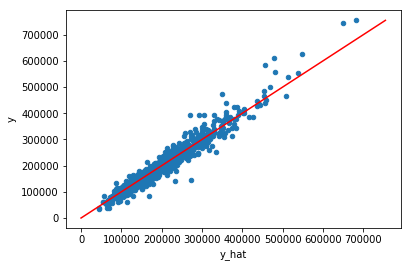

In [358]:
true_line = np.linspace(0, np.expm1(y_train.max()), 50)

pd.DataFrame({'y_hat': np.expm1(y_hats), 'y': np.expm1(y_train)}).plot(
    kind='scatter', x='y_hat', y='y').plot(true_line,
    true_line,  c='red')

In [409]:
coef_df = pd.DataFrame({'cols': X_train.columns,'coef': grid.best_estimator_.coef_}, index=X_train.columns )

In [407]:
pd.DataFrame({'Id': test_raw['Id'], 'SalePrice': test_predictions}).to_csv('/home/gavagai/jails/chromium/Downloads/predictions.csv', index=False)